In [ ]:
dir_csv = '../input/rsna-intracranial-hemorrhage-detection'
dir_train_img = '../input/rsna-train-stage-1-images-png-224x/stage_1_train_png_224x'
dir_test_img = '../input/rsna-test-stage-1-images-png-224x/stage_1_test_png_224x'

In [58]:
dir_csv = dir_dcm = '/home/jupyter/rsna/source_data'
# dir_train_img = '/home/jupyter/rsna/rsna-train-stage-1-images-png-224x/stage_1_train_png_224x'
# dir_test_img = '/home/jupyter/rsna/rsna-train-stage-1-images-png-224x/stage_1_test_png_224x'


In [59]:
import os
from os import path
import cv2
import glob
import pydicom
import numpy as np
# import pandas as pd
import torch
import torch.optim as optim
import sys
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import random
# from pathlib import Path
from sklearn.model_selection import train_test_split, KFold, GroupKFold

from fastai2.torch_basics      import *
from fastai2.data.all          import *
from fastai2.test              import *
from fastai2.medical.imaging   import *



In [2]:
np.random.seed(42)
random.seed(42)

In [3]:
saved = 'saved'
if not path.exists(saved):
    os.mkdir(saved)

In [3]:
dir_csv = dir_dcm = '/home/jupyter/rsna/source_data'

root_path = Path(dir_dcm)
path_trn = root_path/'stage_1_train_images'
fns_trn = path_trn.ls()

path_tst = root_path/'stage_1_test_images'
fns_tst = path_tst.ls()

In [ ]:
# %time df_tst = pd.DataFrame.from_dicoms(fns_tst, px_summ=True, n_workers=8)
# df_tst.to_feather('df_tst.fth')
# df_tst.head()

In [ ]:
# %time df_trn = pd.DataFrame.from_dicoms(fns_trn, px_summ=True, n_workers=8)
# df_trn.to_feather('df_trn.fth')
# df_trn.head()

In [6]:
df_trn = pd.read_feather('df_trn.fth')
df_trn.head()

,SOPInstanceUID,Modality,PatientID,StudyInstanceUID,SeriesInstanceUID,StudyID,ImagePositionPatient,ImageOrientationPatient,SamplesPerPixel,PhotometricInterpretation,...,MultiPixelSpacing,PixelSpacing1,img_min,img_max,img_mean,img_std,MultiWindowCenter,WindowCenter1,MultiWindowWidth,WindowWidth1
0,ID_231d901c1,CT,ID_b81a287f,ID_dd37ba3adb,ID_15dcd6057a,,-125.0,1.0,1,MONOCHROME2,...,1,0.488281,-1024,3263,171.462490,828.102464,NaN,NaN,NaN,NaN
1,ID_994bc0470,CT,ID_400facde,ID_c5277f0c63,ID_4ba12c2161,,-125.0,1.0,1,MONOCHROME2,...,1,0.488281,0,2507,430.418091,599.742963,1.0,47.0,1.0,80.0
2,ID_127689cce,CT,ID_42910d3d,ID_db93ade25b,ID_c4b4931314,,-125.0,1.0,1,MONOCHROME2,...,1,0.488281,-2000,2810,12.801376,1209.046168,NaN,NaN,NaN,NaN
3,ID_25457734a,CT,ID_329aafa7,ID_8dd6d32f3b,ID_116558f409,,-114.0,1.0,1,MONOCHROME2,...,1,0.445312,0,2647,566.557011,610.152845,1.0,36.0,1.0,80.0
4,ID_81c9aa125,CT,ID_6b544c3c,ID_2685c5d5c0,ID_f56d7bd0f9,,-115.0,1.0,1,MONOCHROME2,...,1,0.449219,4,1570,178.512295,358.235071,1.0,36.0,1.0,80.0


In [16]:
df_trn.fname = df_trn.fname.str.replace('../input/rsna-intracranial-hemorrhage-detection/', '/home/jupyter/rsna/source_data/')

In [ ]:
# df_trn.fname = df_trn.fname.str.replace('../input/rsna-intracranial-hemorrhage-detection/', '/home/jupyter/rsna/source_data/')

In [ ]:
example_dicom = pydicom.dcmread(str(fns_trn[0]))
print(example_dicom)

In [ ]:
# https://www.kaggle.com/jhoward/creating-a-metadata-dataframe

def save_lbls():
    path_lbls = path.join(dir_dcm, 'stage_1_train.csv') 
    lbls = pd.read_csv(path_lbls)
    lbls[["ID","htype"]] = lbls.ID.str.rsplit("_", n=1, expand=True)
    lbls.drop_duplicates(['ID','htype'], inplace=True)
    pvt = lbls.pivot('ID', 'htype', 'Label')
    pvt.reset_index(inplace=True)    
    pvt.to_feather('labels.fth')
    
# save_lbls()

In [4]:
df_lbls = pd.read_feather('labels.fth')
df_lbls.head(8)

,ID,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000039fa0,0,0,0,0,0,0
1,ID_00005679d,0,0,0,0,0,0
2,ID_00008ce3c,0,0,0,0,0,0
3,ID_0000950d7,0,0,0,0,0,0
4,ID_0000aee4b,0,0,0,0,0,0
5,ID_0000f1657,0,0,0,0,0,0
6,ID_000178e76,0,0,0,0,0,0
7,ID_00019828f,0,0,0,0,0,0


In [18]:
merge_table = df_lbls.merge(df_trn, left_on='ID', right_on='SOPInstanceUID')
merge_table.head()

,ID,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,SOPInstanceUID,Modality,PatientID,...,MultiPixelSpacing,PixelSpacing1,img_min,img_max,img_mean,img_std,MultiWindowCenter,WindowCenter1,MultiWindowWidth,WindowWidth1
0,ID_000039fa0,0,0,0,0,0,0,ID_000039fa0,CT,ID_eeaf99e7,...,1,0.488281,-2000,2848,13.943810,1195.308120,NaN,NaN,NaN,NaN
1,ID_00005679d,0,0,0,0,0,0,ID_00005679d,CT,ID_18f2d431,...,1,0.460938,-1024,4095,443.519691,903.128368,NaN,NaN,NaN,NaN
2,ID_00008ce3c,0,0,0,0,0,0,ID_00008ce3c,CT,ID_ce8a3cd2,...,1,0.488281,0,2602,491.003143,560.641834,1.0,40.0,1.0,80.0
3,ID_0000950d7,0,0,0,0,0,0,ID_0000950d7,CT,ID_d278c67b,...,1,0.494863,0,1433,60.012962,150.003528,NaN,NaN,NaN,NaN
4,ID_0000aee4b,0,0,0,0,0,0,ID_0000aee4b,CT,ID_ce5f0b6c,...,1,0.423828,10,2368,475.059891,506.609030,1.0,36.0,1.0,80.0


In [8]:
(merge_table.ID == merge_table.SOPInstanceUID).value_counts()

True    674258
dtype: int64

In [40]:
# merge_table = merge_table[merge_table['ID'].isin(png)]
merge_table['Image'] = merge_table.ID

In [11]:
merge_table.head()

,ID,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,SOPInstanceUID,Modality,PatientID,...,PixelSpacing1,img_min,img_max,img_mean,img_std,MultiWindowCenter,WindowCenter1,MultiWindowWidth,WindowWidth1,Image
0,ID_000039fa0,0,0,0,0,0,0,ID_000039fa0,CT,ID_eeaf99e7,...,0.488281,-2000,2848,13.943810,1195.308120,NaN,NaN,NaN,NaN,ID_000039fa0
1,ID_00005679d,0,0,0,0,0,0,ID_00005679d,CT,ID_18f2d431,...,0.460938,-1024,4095,443.519691,903.128368,NaN,NaN,NaN,NaN,ID_00005679d
2,ID_00008ce3c,0,0,0,0,0,0,ID_00008ce3c,CT,ID_ce8a3cd2,...,0.488281,0,2602,491.003143,560.641834,1.0,40.0,1.0,80.0,ID_00008ce3c
3,ID_0000950d7,0,0,0,0,0,0,ID_0000950d7,CT,ID_d278c67b,...,0.494863,0,1433,60.012962,150.003528,NaN,NaN,NaN,NaN,ID_0000950d7
4,ID_0000aee4b,0,0,0,0,0,0,ID_0000aee4b,CT,ID_ce5f0b6c,...,0.423828,10,2368,475.059891,506.609030,1.0,36.0,1.0,80.0,ID_0000aee4b


In [29]:
merge_table.columns

Index(['ID', 'any', 'epidural', 'intraparenchymal', 'intraventricular',
       'subarachnoid', 'subdural', 'SOPInstanceUID', 'Modality', 'PatientID',
       'StudyInstanceUID', 'SeriesInstanceUID', 'StudyID',
       'ImagePositionPatient', 'ImageOrientationPatient', 'SamplesPerPixel',
       'PhotometricInterpretation', 'Rows', 'Columns', 'PixelSpacing',
       'BitsAllocated', 'BitsStored', 'HighBit', 'PixelRepresentation',
       'WindowCenter', 'WindowWidth', 'RescaleIntercept', 'RescaleSlope',
       'fname', 'MultiImagePositionPatient', 'ImagePositionPatient1',
       'ImagePositionPatient2', 'MultiImageOrientationPatient',
       'ImageOrientationPatient1', 'ImageOrientationPatient2',
       'ImageOrientationPatient3', 'ImageOrientationPatient4',
       'ImageOrientationPatient5', 'MultiPixelSpacing', 'PixelSpacing1',
       'img_min', 'img_max', 'img_mean', 'img_std', 'MultiWindowCenter',
       'WindowCenter1', 'MultiWindowWidth', 'WindowWidth1'],
      dtype='object')

In [36]:
merge_table.StudyInstanceUID.nunique()

19530

In [38]:
merge_table.PatientID.nunique()

17079

In [19]:
comb = merge_table
df1 = comb.query('(BitsStored==12) & (PixelRepresentation==0)')
df2 = comb.query('(BitsStored==12) & (PixelRepresentation==1)')
df3 = comb.query('BitsStored==16')
dfs = L(df1,df2,df3)

In [20]:
htypes = 'any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural'

def get_samples(df):
    recs = [df.query(f'{c}==1').sample() for c in htypes]
    recs.append(df.query('any==0').sample())
    return pd.concat(recs).fname.values

sample_fns = concat(*dfs.map(get_samples))

In [21]:
sample_dcms = L(Path(o).dcmread() for o in sample_fns)

In [25]:
sample_dcms[0].scaled_px

(0008, 0018) SOP Instance UID                    UI: ID_aaabae403
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_a0f87d8a'
(0020, 000d) Study Instance UID                  UI: ID_f11c4aa322
(0020, 000e) Series Instance UID                 UI: ID_27fa037eab
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125', '19.8097063', '227.315662']
(0020, 0037) Image Orientation (Patient)         DS: ['1', '0', '0', '0', '0.970295726', '-0.241921896']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.48828125', '0.48828125']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored                         U

In [23]:
samples = torch.stack(tuple(sample_dcms.attrgot('scaled_px')))
bins = samples.freqhist_bins()

In [24]:
type(bins)

torch.Tensor

In [26]:
torch.save(bins, 'sample_bin.pt')

In [27]:
n = torch.load('sample_bin.pt')

In [44]:
save_columns = ['Image', 'fname', 'PatientID', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']

trim_merge_table = merge_table[save_columns]
trim_merge_table.head()

,Image,fname,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any
0,ID_000039fa0,/home/jupyter/rsna/source_data/stage_1_train_images/ID_000039fa0.dcm,ID_eeaf99e7,0,0,0,0,0,0
1,ID_00005679d,/home/jupyter/rsna/source_data/stage_1_train_images/ID_00005679d.dcm,ID_18f2d431,0,0,0,0,0,0
2,ID_00008ce3c,/home/jupyter/rsna/source_data/stage_1_train_images/ID_00008ce3c.dcm,ID_ce8a3cd2,0,0,0,0,0,0
3,ID_0000950d7,/home/jupyter/rsna/source_data/stage_1_train_images/ID_0000950d7.dcm,ID_d278c67b,0,0,0,0,0,0
4,ID_0000aee4b,/home/jupyter/rsna/source_data/stage_1_train_images/ID_0000aee4b.dcm,ID_ce5f0b6c,0,0,0,0,0,0


In [45]:
n_split = 6
random_st = 42



# gkf = GroupKFold(n_splits=n_split, shuffle=True, random_state=random_st)
gkf = GroupKFold(n_splits=n_split)

for fold, (train_index, val_index) in enumerate(gkf.split(trim_merge_table, groups=trim_merge_table.PatientID)):
    train_df = trim_merge_table.iloc[train_index]
    val_df = trim_merge_table.iloc[val_index]
    
    print(f'ins {set(train_df.PatientID) & set(val_df.PatientID)}')
    
    print(f'=> Fold {fold} \n---train---')
    print(train_df.loc[:, ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']].sum())
    print('----val----')
    print(val_df.loc[:, ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']].sum())
    
    train_df.to_csv(f'{saved}/train_fold{fold}.csv', index=False)
    val_df.to_csv(f'{saved}/val_fold{fold}.csv', index=False)

ins set()
=> Fold 0 
---train---
epidural             2294
intraparenchymal    26939
intraventricular    19350
subarachnoid        26471
subdural            35040
any                 79900
dtype: int64
----val----
epidural              467
intraparenchymal     5625
intraventricular     4416
subarachnoid         5651
subdural             7456
any                 17203
dtype: int64
ins set()
=> Fold 1 
---train---
epidural             2315
intraparenchymal    27065
intraventricular    19825
subarachnoid        26692
subdural            35324
any                 81140
dtype: int64
----val----
epidural              446
intraparenchymal     5499
intraventricular     3941
subarachnoid         5430
subdural             7172
any                 15963
dtype: int64
ins set()
=> Fold 2 
---train---
epidural             2365
intraparenchymal    27249
intraventricular    20098
subarachnoid        26735
subdural            36060
any                 81656
dtype: int64
----val----
epidural            

In [ ]:
train_df.head()

In [ ]:
# Also prepare the test data

test[['ID','Image','Diagnosis']] = test['ID'].str.split('_', expand=True)
test['Image'] = 'ID_' + test['Image']
test = test[['Image', 'Label']]
test.drop_duplicates(inplace=True)

test.to_csv(f'{saved}/test.csv', index=False)

In [65]:
df_tst = pd.read_feather('df_tst.fth')
df_tst['Image'] = df_tst.PatientID
df_tst.head()

,SOPInstanceUID,Modality,PatientID,StudyInstanceUID,SeriesInstanceUID,StudyID,ImagePositionPatient,ImageOrientationPatient,SamplesPerPixel,PhotometricInterpretation,...,img_min,img_max,img_mean,img_std,img_pct_window,MultiWindowCenter,WindowCenter1,MultiWindowWidth,WindowWidth1,Image
0,ID_86f6b1f4d,CT,ID_a890da25,ID_bb55f7ae9a,ID_dac263a44a,,-125.0,1.0,1,MONOCHROME2,...,-2000,2615,50.499954,1202.048546,0.115082,NaN,NaN,NaN,NaN,ID_a890da25
1,ID_ee8c97227,CT,ID_8ae7e2f2,ID_e973f250d4,ID_4d7aec076b,,-125.0,1.0,1,MONOCHROME2,...,-2000,2782,105.351711,1244.912906,0.228115,NaN,NaN,NaN,NaN,ID_8ae7e2f2
2,ID_564b483a0,CT,ID_810e2735,ID_ce32b7cf30,ID_b5ddb6c064,,-125.0,1.0,1,MONOCHROME2,...,-2000,3059,-34.592339,1142.943129,0.126568,NaN,NaN,NaN,NaN,ID_810e2735
3,ID_e48eea98e,CT,ID_42940b2c,ID_6ae111f642,ID_68a71e367e,,-125.0,1.0,1,MONOCHROME2,...,-2000,2892,199.978889,1279.431411,0.302895,NaN,NaN,NaN,NaN,ID_42940b2c
4,ID_264587c36,CT,ID_8a25d4eb,ID_13d633652e,ID_8257edc0f8,,-125.0,1.0,1,MONOCHROME2,...,-2000,1931,-590.567207,1070.949286,0.005836,NaN,NaN,NaN,NaN,ID_8a25d4eb


In [63]:
df_tst.columns

Index(['SOPInstanceUID', 'Modality', 'PatientID', 'StudyInstanceUID',
       'SeriesInstanceUID', 'StudyID', 'ImagePositionPatient',
       'ImageOrientationPatient', 'SamplesPerPixel',
       'PhotometricInterpretation', 'Rows', 'Columns', 'PixelSpacing',
       'BitsAllocated', 'BitsStored', 'HighBit', 'PixelRepresentation',
       'WindowCenter', 'WindowWidth', 'RescaleIntercept', 'RescaleSlope',
       'fname', 'MultiImagePositionPatient', 'ImagePositionPatient1',
       'ImagePositionPatient2', 'MultiImageOrientationPatient',
       'ImageOrientationPatient1', 'ImageOrientationPatient2',
       'ImageOrientationPatient3', 'ImageOrientationPatient4',
       'ImageOrientationPatient5', 'MultiPixelSpacing', 'PixelSpacing1',
       'img_min', 'img_max', 'img_mean', 'img_std', 'img_pct_window',
       'MultiWindowCenter', 'WindowCenter1', 'MultiWindowWidth',
       'WindowWidth1', 'Image'],
      dtype='object')

In [66]:

df_tst.fname = df_tst.fname.str.replace('../input/rsna-intracranial-hemorrhage-detection/', '/home/jupyter/rsna/source_data/')
df_tst.head()

,SOPInstanceUID,Modality,PatientID,StudyInstanceUID,SeriesInstanceUID,StudyID,ImagePositionPatient,ImageOrientationPatient,SamplesPerPixel,PhotometricInterpretation,...,img_min,img_max,img_mean,img_std,img_pct_window,MultiWindowCenter,WindowCenter1,MultiWindowWidth,WindowWidth1,Image
0,ID_86f6b1f4d,CT,ID_a890da25,ID_bb55f7ae9a,ID_dac263a44a,,-125.0,1.0,1,MONOCHROME2,...,-2000,2615,50.499954,1202.048546,0.115082,NaN,NaN,NaN,NaN,ID_a890da25
1,ID_ee8c97227,CT,ID_8ae7e2f2,ID_e973f250d4,ID_4d7aec076b,,-125.0,1.0,1,MONOCHROME2,...,-2000,2782,105.351711,1244.912906,0.228115,NaN,NaN,NaN,NaN,ID_8ae7e2f2
2,ID_564b483a0,CT,ID_810e2735,ID_ce32b7cf30,ID_b5ddb6c064,,-125.0,1.0,1,MONOCHROME2,...,-2000,3059,-34.592339,1142.943129,0.126568,NaN,NaN,NaN,NaN,ID_810e2735
3,ID_e48eea98e,CT,ID_42940b2c,ID_6ae111f642,ID_68a71e367e,,-125.0,1.0,1,MONOCHROME2,...,-2000,2892,199.978889,1279.431411,0.302895,NaN,NaN,NaN,NaN,ID_42940b2c
4,ID_264587c36,CT,ID_8a25d4eb,ID_13d633652e,ID_8257edc0f8,,-125.0,1.0,1,MONOCHROME2,...,-2000,1931,-590.567207,1070.949286,0.005836,NaN,NaN,NaN,NaN,ID_8a25d4eb


In [67]:
df_tst = df_tst[['Image', 'fname']]
df_tst.head()

,Image,fname
0,ID_a890da25,/home/jupyter/rsna/source_data/stage_1_test_images/ID_86f6b1f4d.dcm
1,ID_8ae7e2f2,/home/jupyter/rsna/source_data/stage_1_test_images/ID_ee8c97227.dcm
2,ID_810e2735,/home/jupyter/rsna/source_data/stage_1_test_images/ID_564b483a0.dcm
3,ID_42940b2c,/home/jupyter/rsna/source_data/stage_1_test_images/ID_e48eea98e.dcm
4,ID_8a25d4eb,/home/jupyter/rsna/source_data/stage_1_test_images/ID_264587c36.dcm


In [68]:
df_tst.to_csv(f'{saved}/test.csv', index=False)

In [87]:
dcm = Path(df_tst.fname[0]).dcmread()
x = dcm.hist_scaled_px(bins)

In [88]:
x.shape

torch.Size([512, 512])

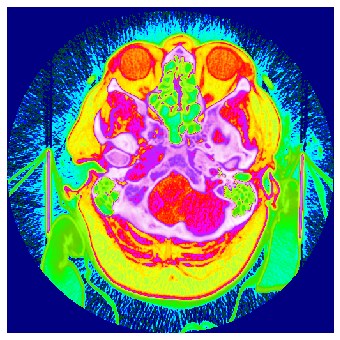

In [85]:
dcm.show(cmap=plt.cm.gist_ncar, figsize=(6,6))